<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/vasicekBaselRho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import urllib.request
import pickle

from scipy.stats import norm

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Define plot matrix function
def plotMatrix(data, plotName, format = True):
  if format is True:
    fmtType = '.2%'
  else:
    fmtType = '.4g'
  plt.figure(figsize = (14, 9))
  plt.title(f'{plotName}')
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = fmtType,
      xticklabels = True,
      yticklabels = True,
      cmap = 'RdYlGn_r',
      cbar = False
  )
  ax.xaxis.tick_top() #x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

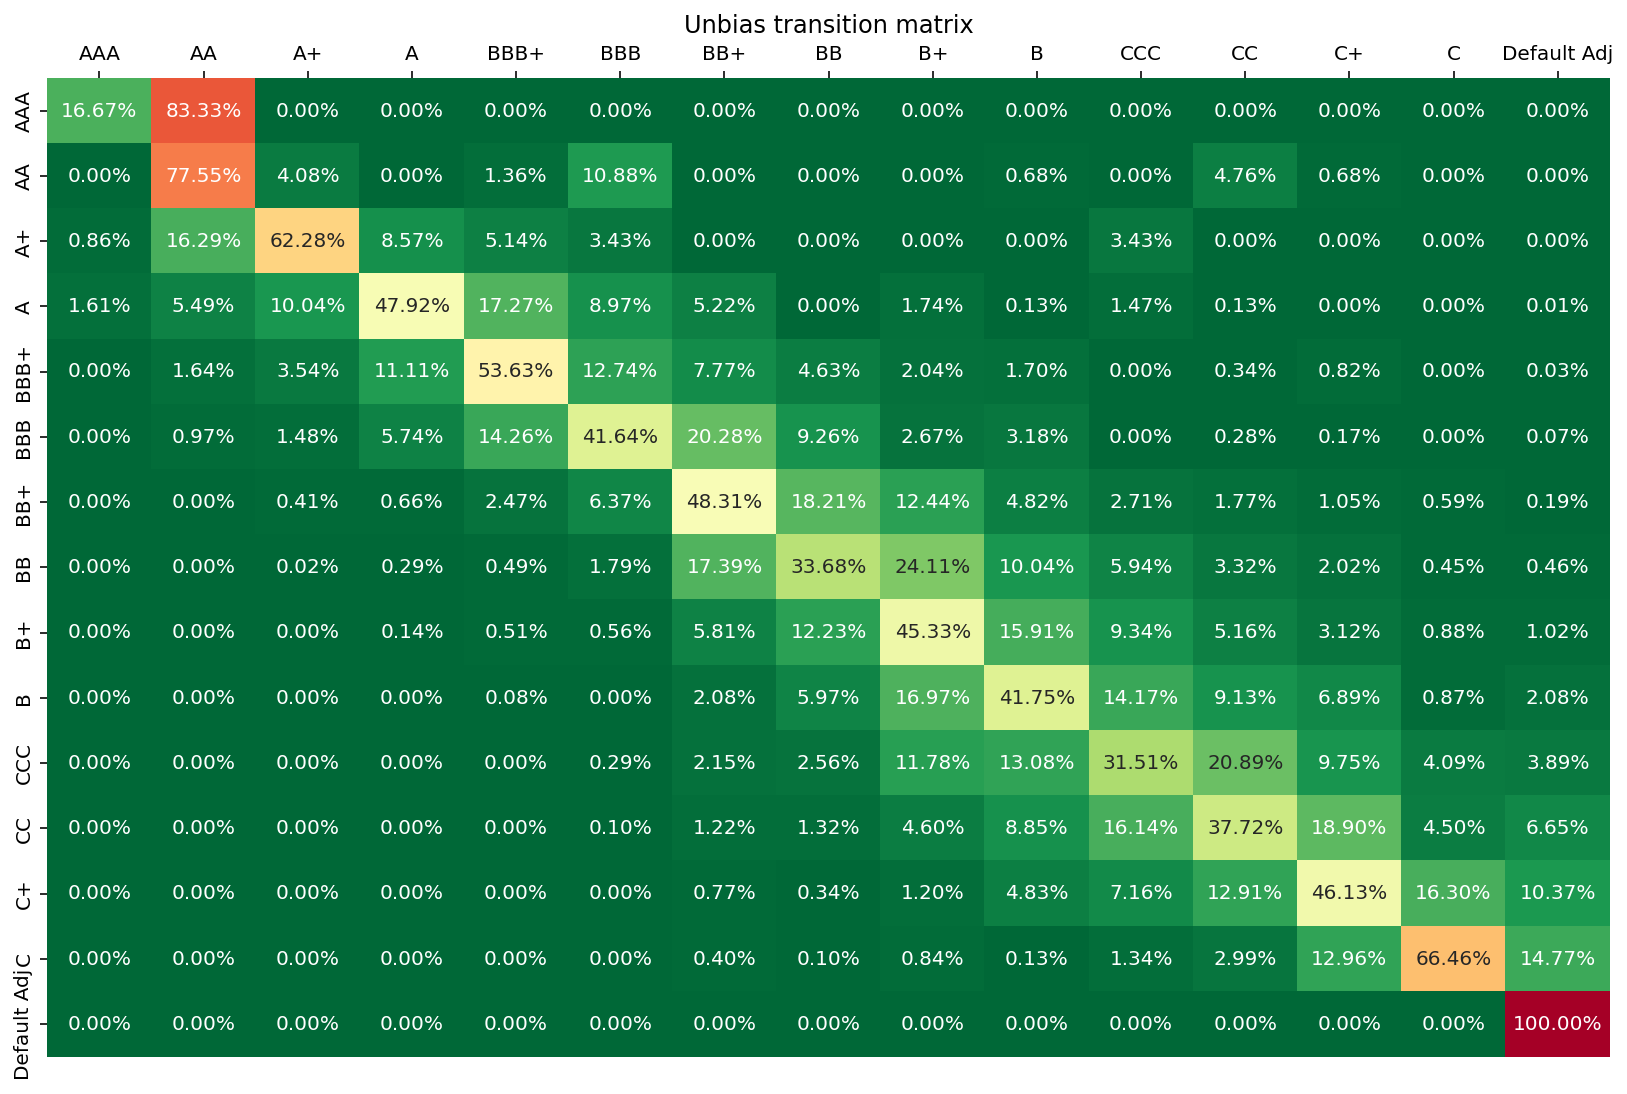

In [4]:
# Import dataset of transition matrix
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/matrixAdjustment.csv'
).drop(
    ['N'],
    axis = 1
)

# Assign index to be the same as columns
df.index = df.columns

# Plot
plotMatrix(df, 'Unbias transition matrix')

### Basel asset correlation
The Credit Cycle Index model with the Vasicek formula required the asset correlation or $\rho$ as shown in below equation:

\begin{align}
        PD_{PiT, i} = \Phi\left(\frac{\Phi^{-1}(PD_{TTC, i}) + \sqrt{\rho} * CF'}{\sqrt{1 - \rho}}\right)
    \end{align}

where;
- $\rho$ is the Basel asset correlation

The Basel asset correlation, $\rho$ defines the relationship of the shift in distribution with the Economy. For the purpose of the modelling, the Basel asset correlation can be calculated as below:

\begin{align}
        \rho = 0.12\left(\frac{1 - \exp(-50 * PD_{TTC,i})}{1 - \exp(-50)}\right) + 0.24 \left(1 - \frac{1 - \exp(-50 * PD_{TTC,i})}{1 - \exp(-50)}\right)
    \end{align}

where;
- $PD_{TTC,i}$ is the unbias TTC PD from the rating model or scoring model on each rating


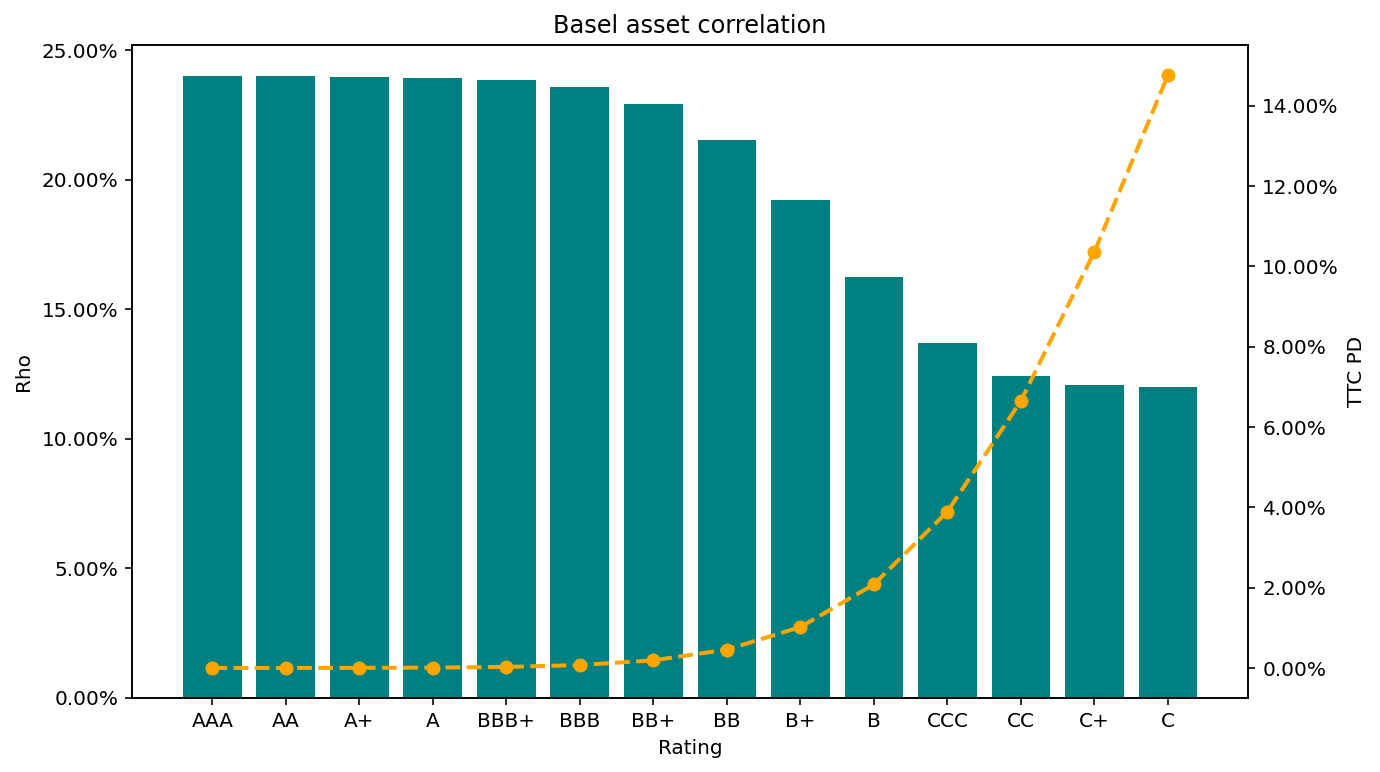

In [5]:
# TTC PD
ttc = df['Default Adj'].iloc[:-1] #Without default row

# Basel asset correlation
rho = 0.12 * ((1 - np.exp(-50 * ttc)) / (1 - np.exp(-50))) + \
      0.24 * (1 - ((1 - np.exp(-50 * ttc)) / (1 - np.exp(-50))))

# Plot
plt.figure(figsize = (10, 6))
plt.title('Basel asset correlation')
plt.xlabel('Rating')
plt.bar(
    rho.index,
    rho,
    color = 'teal'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.ylabel('Rho')
plt.twinx()
plt.plot(
    ttc,
    color = 'orange',
    linewidth = 2,
    linestyle = '--',
    marker = 'o'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.ylabel('TTC PD')
plt.show()

In [6]:
# Load FWL Trained model
link = 'https://github.com/naenumtou/ifrs9/blob/main/PD/model/FWLModelBOT.pk?raw=true'
FWLModel = pickle.load(
    urllib.request.urlopen(link)
)
print(FWLModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     13.87
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           0.000134
Time:                        13:15:30   Log-Likelihood:                 53.695
No. Observations:                  19   AIC:                            -99.39
Df Residuals:                      15   BIC:                            -95.61
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6996      1.531     -1.764      0.0

In [7]:
# Forecast for 3 years
# Assumed macroeconomics variables
XForecast = np.array(
    [
     [1, 0.055, 0.045, 102.1],
     [1, 0.045, 0.07, 101.5],
     [1, 0.076, 0.06, 103.6]
    ]
)

# Z-Index prediction
ZPred = FWLModel.predict(XForecast)
print(f'Predicted Z-Index\n{ZPred}')

Predicted Z-Index
[-2.1567599  -2.15244609 -2.13842363]


In [8]:
# Load average of dependence variable
link = 'https://github.com/naenumtou/ifrs9/blob/main/PD/model/FWLAverageBOT.pk?raw=true'
average = pickle.load(
    urllib.request.urlopen(link)
)
print(f'Average of dependence variable: {average:.4f}')

Average of dependence variable: -2.1864


In [9]:
# Z-Index (Standardized)
mean = average / np.sqrt(1 - rho)
std = np.sqrt(rho) / np.sqrt(1 - rho)

ZSTD = []

for i in range(len(ZPred)):
  ZSTD.append((ZPred[i] - mean) / std)

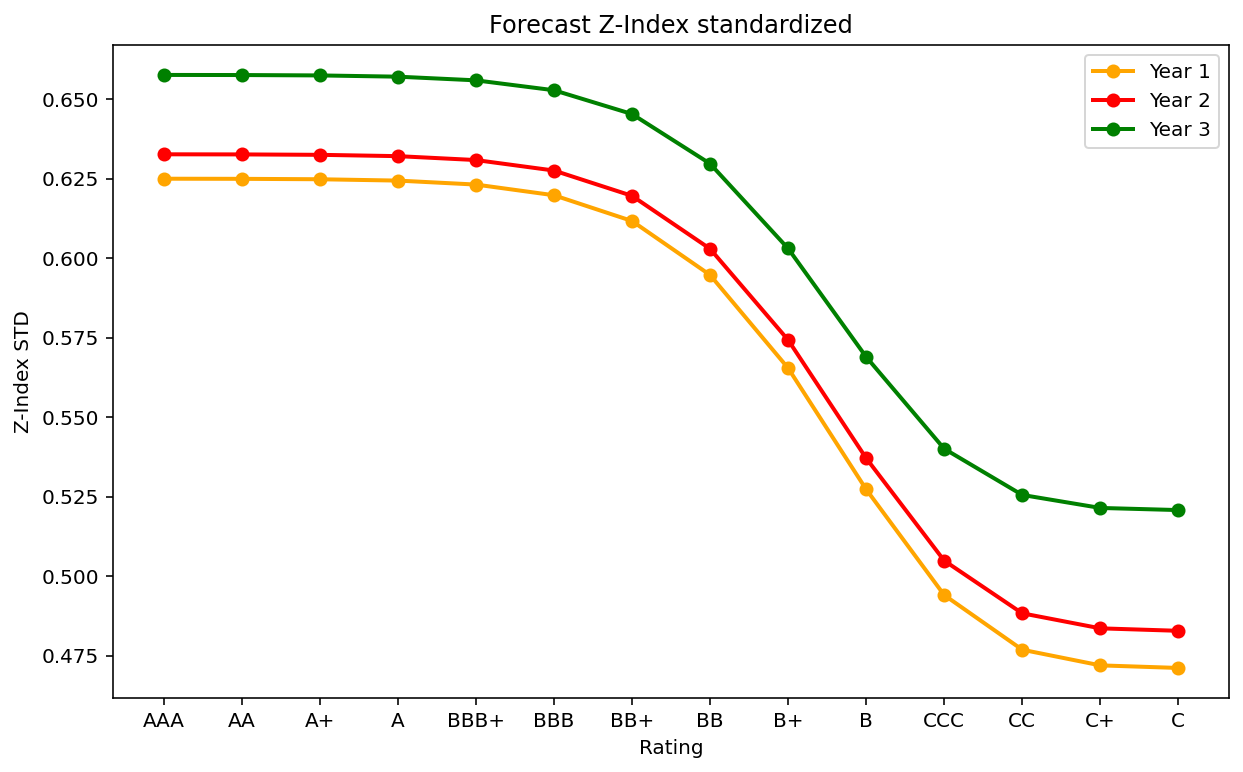

In [10]:
# Plot
colors = ['orange', 'red', 'green']

plt.figure(figsize = (10, 6))
plt.title('Forecast Z-Index standardized')
for i, color in zip(range(len(ZSTD)), colors):
  plt.plot(
      ZSTD[i].index,
      ZSTD[i],
      color = color,
      linewidth = 2,
      marker = 'o',
      label = f'Year {i + 1}'
  )
plt.ylabel('Z-Index STD')
plt.xlabel('Rating')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [11]:
# Vasicek PD
vasicekPD = []

for i in range(len(ZSTD)):
  vasicekPD.append(
      norm.cdf(
          (
              norm.ppf(ttc) - np.sqrt(rho) * ZSTD[i]
          ) / np.sqrt(1 - rho)
      )
  )

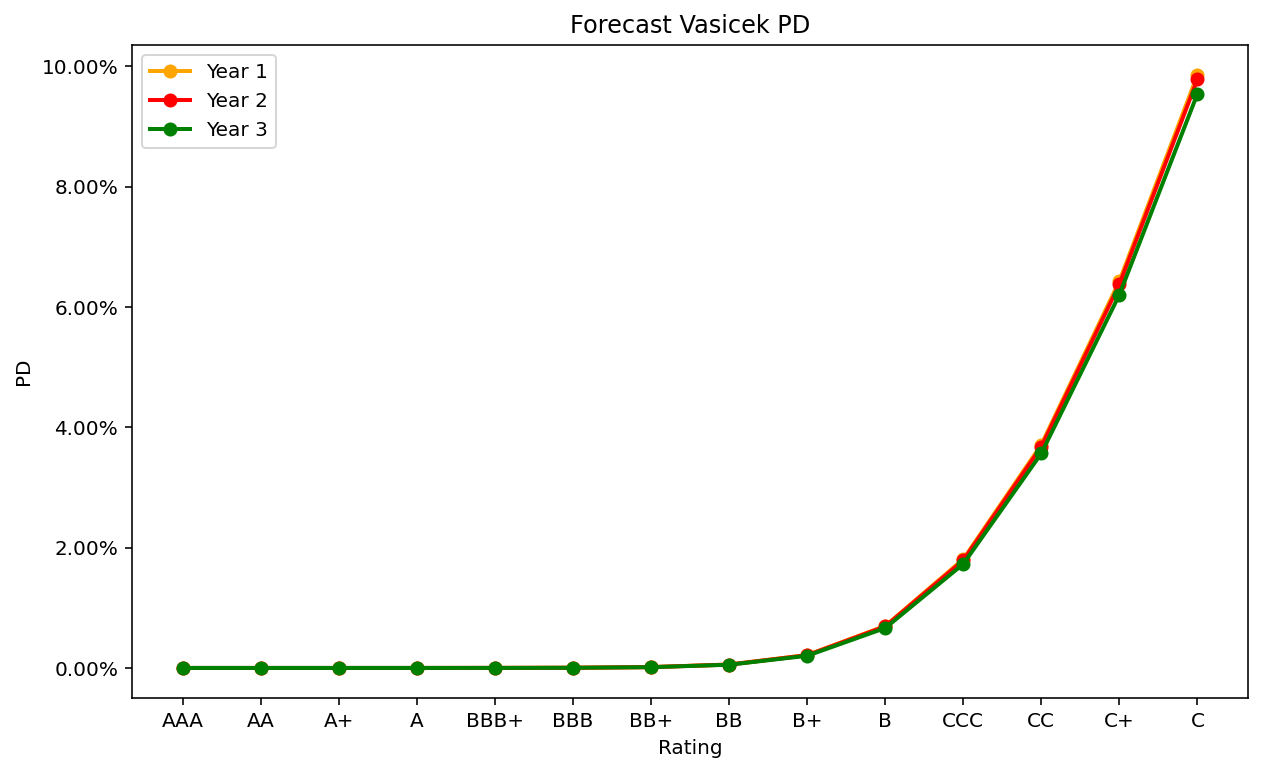

In [12]:
# Plot
plt.figure(figsize = (10, 6))
plt.title('Forecast Vasicek PD')
for i, color in zip(range(len(vasicekPD)), colors):
  plt.plot(
      ZSTD[i].index,
      vasicekPD[i],
      color = color,
      linewidth = 2,
      marker = 'o',
      label = f'Year {i + 1}'
  )
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.ylabel('PD')
plt.xlabel('Rating')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [13]:
# Define function rate matrix adjustment
def adjMatrix(data, oldRate, newRate):
  adjRate = (1 - data[newRate]).values / (1 - data[oldRate]).values
  matrixAdj = data.drop(
      [oldRate, newRate],
      axis = 1
  ).mul(
      adjRate,
      axis = 0
  ).fillna(0)
  matrixAdj[f'{newRate}'] = list(data[newRate])
  return matrixAdj

In [14]:
# Adjust matrix with Vasicek PD
matrixForecast = []

for i in range(3):
  matrixAdj = df.copy()
  matrixAdj['Vasicek PD'] = np.hstack(
      (vasicekPD[i], 1)
  ) #Stack with 100% Default rate
  matrixAdj = adjMatrix(matrixAdj, 'Default Adj', 'Vasicek PD')
  matrixForecast.append(matrixAdj)

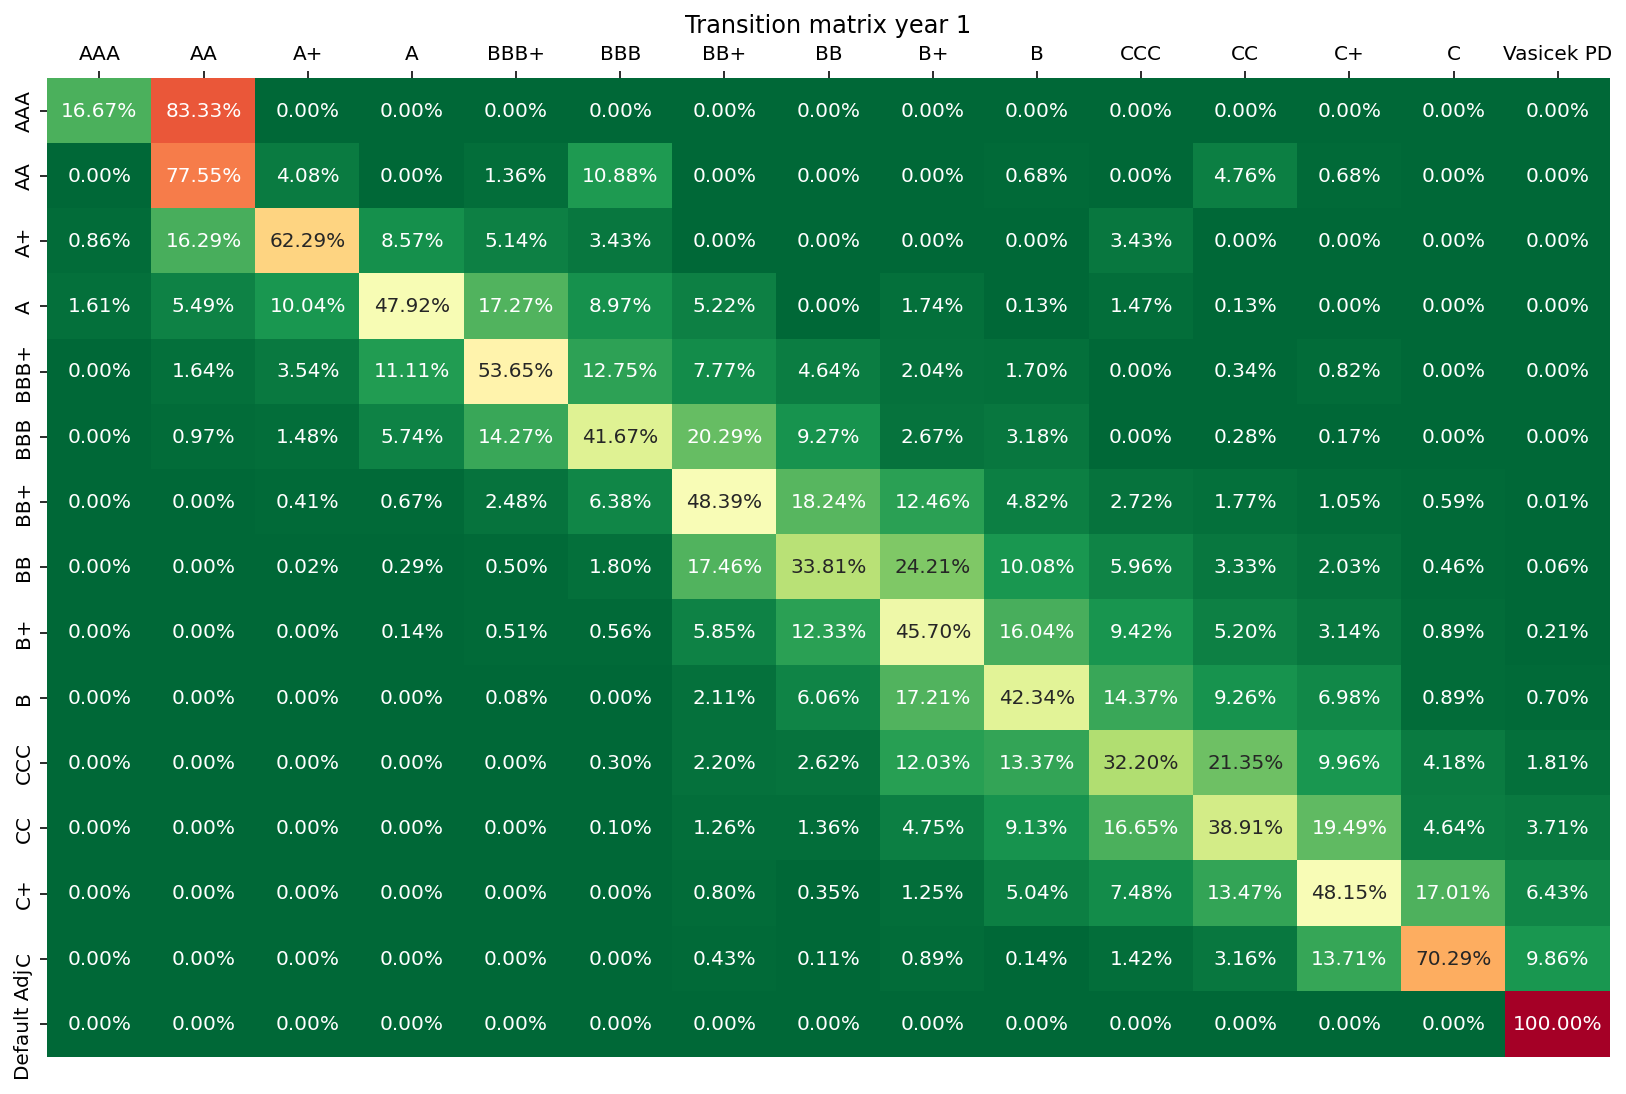

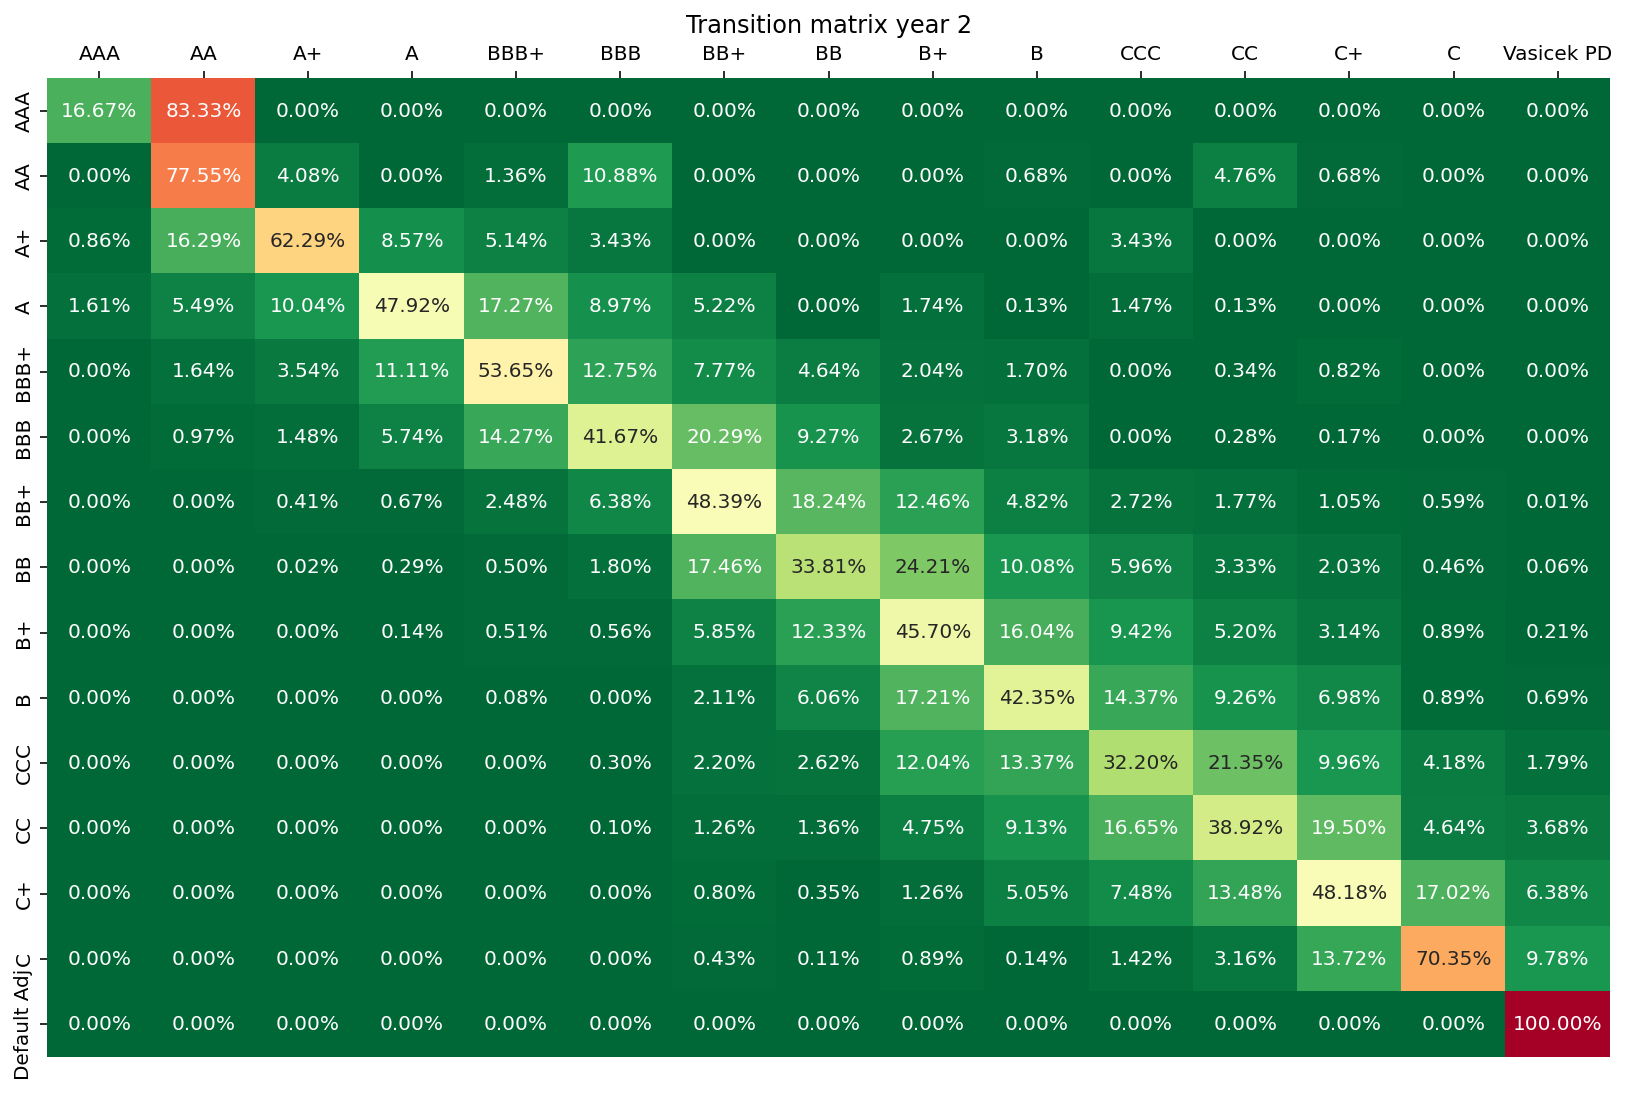

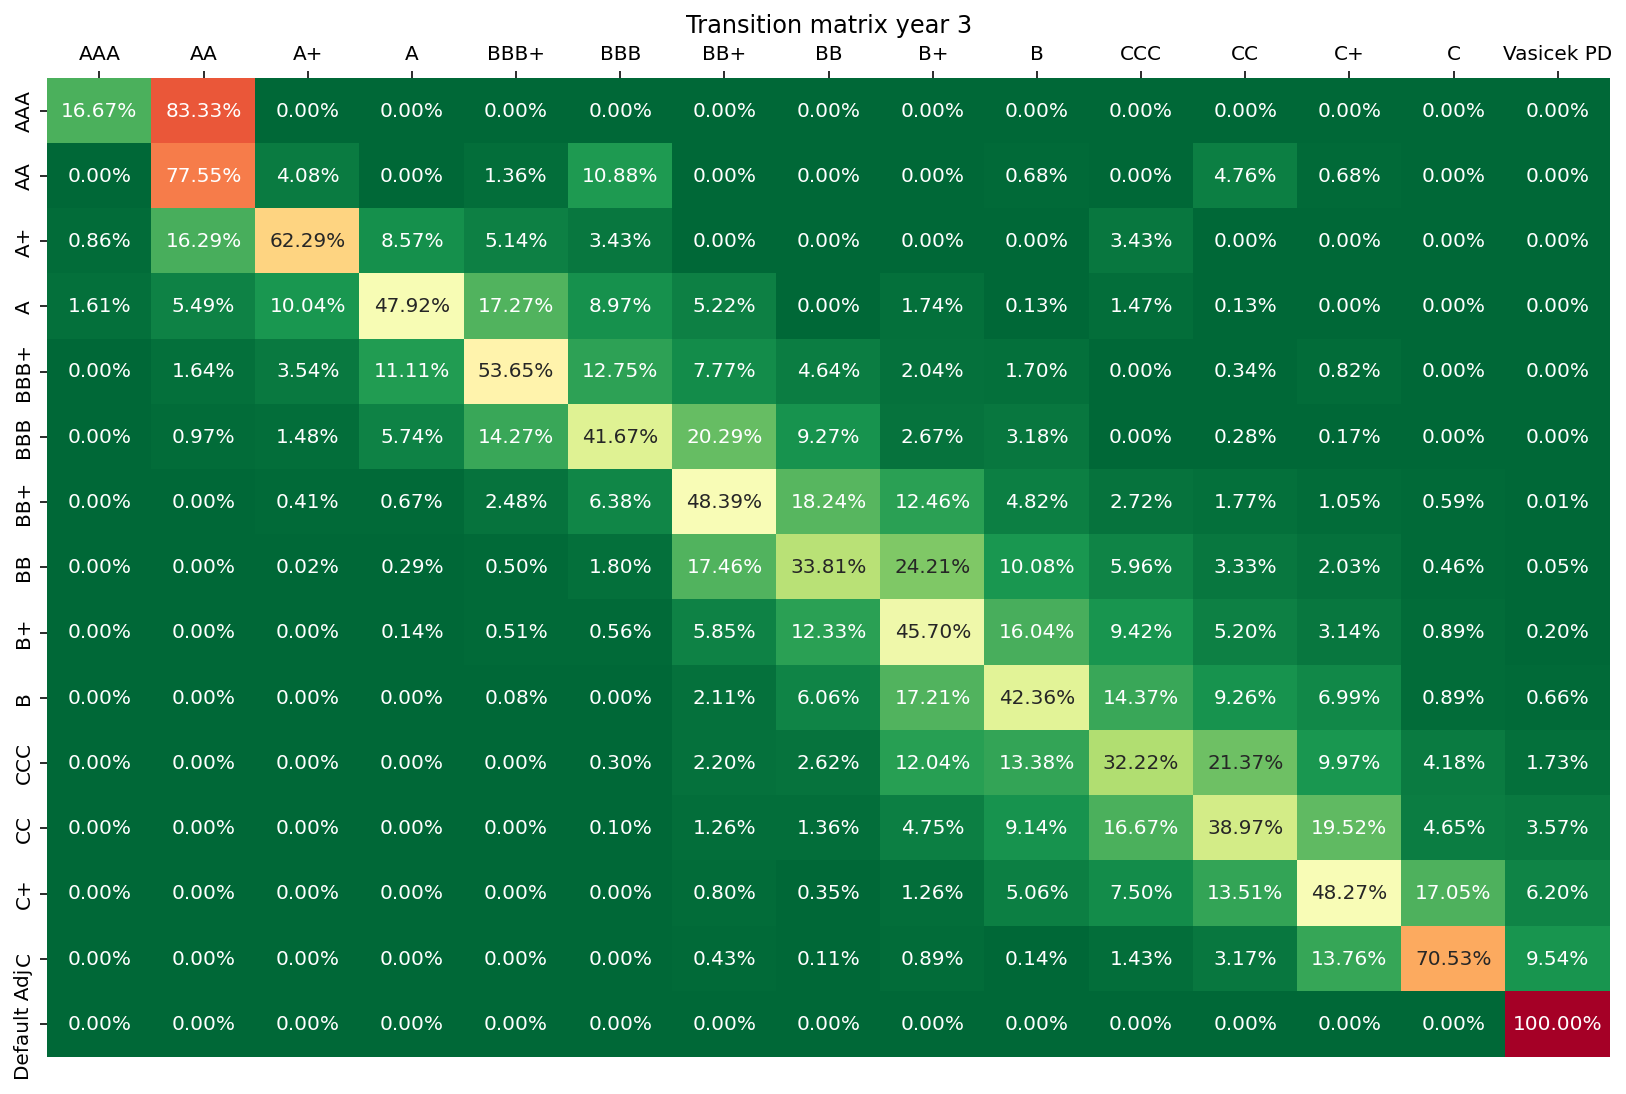

In [15]:
# Plot
for i in range(len(matrixForecast)):
  plotMatrix(matrixForecast[i], f'Transition matrix year {i + 1}')

In [16]:
# Matrix multiplication for lifetime
years = 15 #Create lifetime PD for 15-years
lifetimeResults = None

lifetime = matrixForecast[0].to_numpy() #Year 1 matrix as the based
lifetimePD = lifetime[:, -1][:-1] #Keep first year PD but not 'Default' row
indexRating = matrixForecast[0].index #Keep index rating

for i in range(years):
  if i == 0:
    pass
  elif i < len(matrixForecast):
    lifetimeCum = np.matmul(
        lifetime[-len(indexRating):, :],
        matrixForecast[i]
    ) #Base * next year forecast
    lifetime = np.vstack((lifetime, lifetimeCum))
    lifetimePD = np.vstack((lifetimePD, lifetimeCum.iloc[:-1, -1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(
        lifetimePD,
        columns = indexRating[:-1]
    ) #Format to DataFrame
  else:
    lifetimeCum = np.matmul(
        lifetime[-len(indexRating):, :], #Latest forecasted matrix
        matrixForecast[0] #Base TTC Matrix
    ) #Mean reversion
    lifetime = np.vstack((lifetime, lifetimeCum)) #Keep cumulative matrix
    lifetimePD = np.vstack((lifetimePD, lifetimeCum.iloc[:-1, -1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(
        lifetimePD,
        columns = indexRating[:-1]
    ) #Format to DataFrame
if lifetimeResults is None:
  lifetimeResults = lifetimeResult.copy()
else:
  lifetimeResults = pd.concat(
      [lifetimeResults, lifetimeResult],
      axis = 0,
      ignore_index = False
  ) #Keep index

In [17]:
# Long table format
lifetimeResults['times'] = pd.date_range(
    start = '1/12/2018',
    periods = years,
    freq = 'Y'
)
lifetimeResults = pd.melt(
    lifetimeResults,
    id_vars = 'times',
    var_name = 'Rating',
    value_name = 'Cumulative PD'
)
lifetimeResults.head(5)

,times,Rating,Cumulative PD
0,2018-12-31,AAA,6.925575e-09
1,2019-12-31,AAA,4.558274e-08
2,2020-12-31,AAA,1.807938e-03
3,2021-12-31,AAA,5.462068e-03
4,2022-12-31,AAA,1.070503e-02


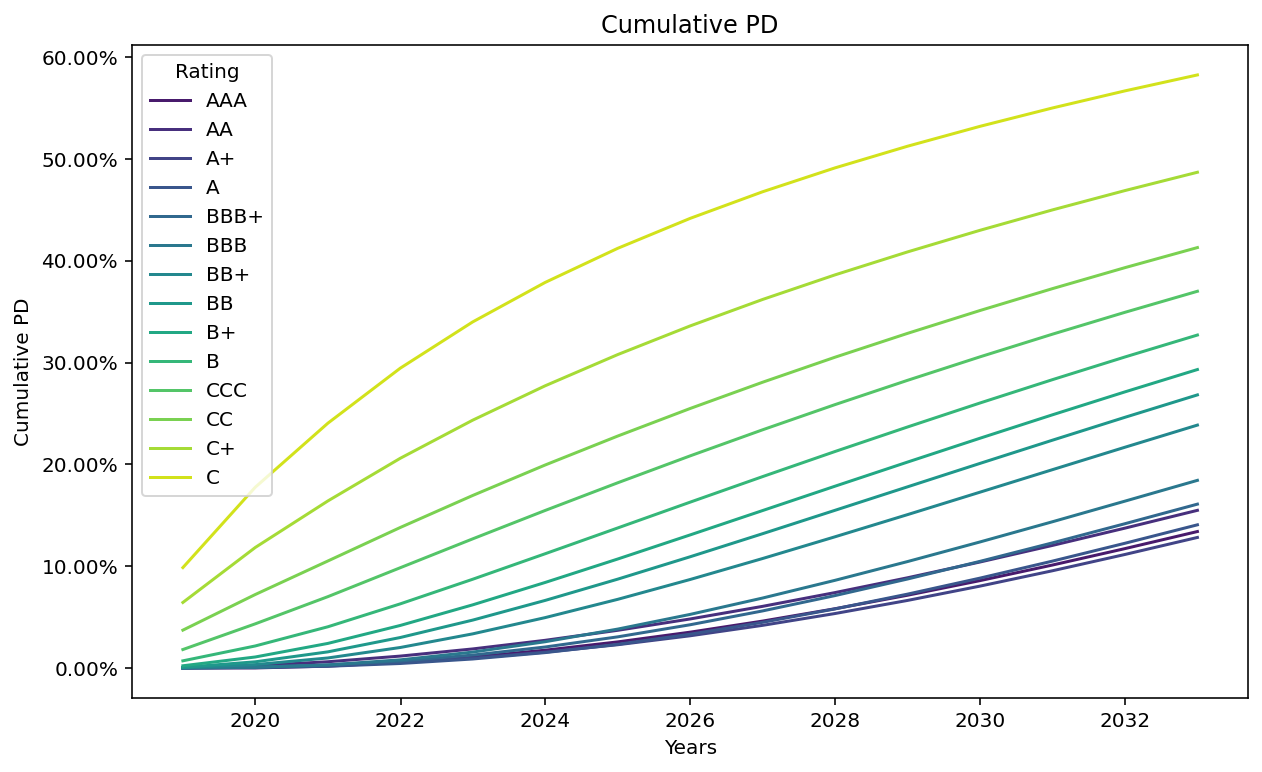

In [18]:
# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'times',
    y = 'Cumulative PD',
    data = lifetimeResults,
    hue = 'Rating',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
ax.set_title('Cumulative PD')
ax.set(xlabel = 'Years', ylabel = 'Cumulative PD')
plt.show()